In [2]:
# setup

#import required/useful libraries
import nltk
import pandas as pd
import matplotlib
import numpy as np
import urllib.request

print('finished processing import statements')


#Read in data
prefix = "https://raw.githubusercontent.com/annajordanous/COMP6481-8481/main/"
suffix = ".pdf.txt"
samples = ["instb", "unitb", "instw", "unitw"]
b_env = ["TheUniversityofBirmingham", "TheUniversityofSheffield", "UniversityofNottingham,The", 
         "TheUniversityofLancaster", "UniversityofBristol", "UniversityofSouthampton", 
         "TheUniversityofManchester", "UniversityofDundee", "UniversityofYork"]
w_env = ["AstonUniversity", "BirkbeckCollege", "LiverpoolJohnMooresUniversity",
         "ManchesterMetropolitanUniversity", "NottinghamTrentUniversity", "TheUniversityofHuddersfield",
         "TheUniversityofWestLondon", "UniversityofEastLondon", "UniversityofStirling"]
k_env = ["TheUniversityofKent"]
instb = {}
instw = {}
instk = {}
unitb = {}
unitw = {}
unitk = {}

def readURL(filename):
    # open a connection to a URL using urllib
    webUrl  = urllib.request.urlopen(filename)
    # read the data from the URL and print it
    data = webUrl.read()
    return data
    
def readFiles(x, tag):
    itag = "inst"+tag
    filenameI = prefix+itag+"/"+itag+x+suffix
    utag = "unit"+tag
    filenameU = prefix+utag+"/"+utag+x+"-11"+suffix
    dataI = str(readURL(filenameI))
    dataU = str(readURL(filenameU))
    return(dataI, dataU)

print("finished setting up variables and functions for data readin")


# this cell may take some time to run

# read in textual data 
for x in b_env:
    (instb[x], unitb[x]) = readFiles(x, "b")
    
for x in w_env:
    (instw[x], unitw[x]) = readFiles(x, "w")

for x in k_env:
    (instk[x], unitk[x]) = readFiles(x, "k")
    
print("Finished reading in textual data")

finished processing import statements
finished setting up variables and functions for data readin
Finished reading in textual data


In [3]:
# topic modelling 

from nltk.corpus import stopwords
import re
#from nltk.tokenize import RegexpTokenizer
#import string

## preprocess: lower -> tokens -> stems
def preprocess(text, stops):
    text = text.lower()
    sent_text = nltk.sent_tokenize(text)
    # get rid of \\n tokens (newlines) from pdf -> txt conversion
    sent_text = [x.replace('\\n','') for x in sent_text]
    # get rid of pdf unicode escape tokens from pdf -> text converstion
    pdf_escape_pattern = re.compile(r'\\\\x[a-fA-F0-9]{2}')
    sent_text = [pdf_escape_pattern.sub('', x.encode('unicode_escape').decode()) for x in sent_text]

    #pdf_escape_pattern = re.compile(r'\\\\x[a-fA-F0-9]{2}')
    #sent_text = [token for token in sent_text if not pdf_escape_pattern.search(token)]
    tok_text = [nltk.word_tokenize(s) for s in sent_text]
    porter = nltk.stem.PorterStemmer()
    porter = nltk.stem.PorterStemmer()
    new_tok_text = []
    for t in tok_text:
        new_t = []
        for o in t:
            if o not in stops:
                new_t.append(porter.stem(o))
        new_tok_text.append(new_t)
    return new_tok_text

# setup text for topic modelling
def setuptext(text):
    stopwords_set = set(stopwords.words("english"))
    punct = set([",", ".", "(", ")", "[", "]", ":", "\\n", "''", ";"])
    freq_words = set(["e.g", "includ", "see", "also", "research", "school", "staff", "ref2021" "li", "student", "support", "impact"])
    stopwords_set = stopwords_set.union(punct)
    stopwords_set = stopwords_set.union(freq_words)
    new_tok_en_u = preprocess(text, stopwords_set)
    return new_tok_en_u

# create a text for every uni, so we will have a model with each
def createTextForEach():
    for x in b_env:
        texts_tm[x] = setuptext(unitb[x])
    for x in w_env:
        texts_tm[x] = setuptext(unitw[x])
    for x in k_env:
        texts_tm[x] = setuptext(unitk[x])

# create 3 texts, for better, kent, and worse, so we will have three models
def createThreeTexts():
    better_text = ""
    for x in b_env:
        better_text+=unitb[x]
    texts_tm["BetterUniversities"] = setuptext(better_text)
    worse_text = ""
    for x in w_env:
        worse_text+=unitw[x]
    texts_tm["WorseUniversities"] = setuptext(worse_text)
    for x in k_env:
        texts_tm["TheUniversityofKent"] = setuptext(unitk[x])
        
# create one text, so we will have one model
def createAText():
    all_texts = []
    for x in b_env:
        all_texts+=unitb[x]
    for x in w_env:
        all_texts+=unitb[x]
    for x in k_env:
        all_texts+=unitb[x]
    texts_tm["AllUniversities"] = setuptext(all_texts)

texts_tm = {}
#createTextForEach()
createThreeTexts()
print(texts_tm.keys())
#createAText()

dict_keys(['BetterUniversities', 'WorseUniversities', 'TheUniversityofKent'])


In [4]:
# identify topics in data with LDA
from gensim import models
from gensim.corpora.dictionary import Dictionary

texts_dict_corp = {}
# setup dicts/corpus for all texts
for text in texts_tm:
    texts_dict_corp[text] = {}
    texts_dict_corp[text]["dict"] = u_dictionary = Dictionary(texts_tm[text])
    texts_dict_corp[text]["corpus"] = [u_dictionary.doc2bow(tx) for tx in texts_tm[text]]

In [5]:
import warnings
# for nmp errs
warnings.filterwarnings("ignore", category=DeprecationWarning) 

text_models = {
    "lda": {},
    "nmf": {},
    "lsi": {},
}

def ldaM(uni):
    u_dict = texts_dict_corp[uni]["dict"] 
    u_corpus = texts_dict_corp[uni]["corpus"]

    # few topics since we have lots of models
    lda = models.ldamodel.LdaModel(u_corpus, num_topics=3, id2word=u_dict, passes=40)
    text_models["lda"][uni] = lda
    topics = lda.show_topics(formatted=False)
    # Train the model on the corpus, with 10 passes, to look for 5 topics
    print(uni)
    for t in topics:
        #print(t)
        print(t[0], [x[0] for x in t[1]])
    print()
    
def nmfM(uni):
    u_dict = texts_dict_corp[uni]["dict"] 
    u_corpus = texts_dict_corp[uni]["corpus"]

    nmf = models.nmf.Nmf(u_corpus, num_topics=3, id2word=u_dict, passes=40)
    text_models["nmf"][uni] = nmf
    topics = nmf.show_topics(formatted=False, num_topics=3)
    print(uni)
    for t in topics:
        print(t[0], [x[0] for x in t[1]])
    print()
        
def lsiM(uni):
    u_dict = texts_dict_corp[uni]["dict"] 
    u_corpus = texts_dict_corp[uni]["corpus"]

    lsi = models.LsiModel(u_corpus, num_topics=3, id2word=u_dict) #lsi does not require passes parameter
    text_models["lsi"][uni] = lsi
    topics = lsi.show_topics(formatted=False, num_topics=3)
    print(uni)
    for t in topics:
        print(t[0], [x[0] for x in t[1]])
    print()

# create model for all the texts (so relative to texts we set up earlier)
def createAllLda():
    # could me individual uni's, or could be groups of uni's
    for uni in texts_tm.keys():
        ldaM(uni)

# create specific lda for however many unis
def create3Lda():
    # better
    ldaM("TheUniversityofBirmingham")
    # worse
    ldaM("AstonUniversity")
    # kent
    ldaM("TheUniversityofKent")
    
createAllLda()

BetterUniversities
0 ['student', 'fund', 'includ', 'develop', '%', 'academ', 'period', 'work', 'provid', 'environ']
1 ['comput', 'unit', 'user', 'host', 'univers', 'invit', 'argument', 'includ', 'sicsa', 'cluster']
2 ['system', 'comput', 'univers', 'scienc', 'collabor', 'includ', 'centr', 'technolog', 'secur', 'fund']

WorseUniversities
0 ['%', 'fund', 'collabor', 'project', 'develop', 'includ', 'period', 'grant', 'work', 'incom']
1 ['comput', 'intern', 'data', 'collabor', 'univers', 'ieee', 'confer', 'scienc', 'system', 'technolog']
2 ['develop', 'student', 'univers', 'fund', 'provid', 'train', 'includ', 'phd', 'academ', 'new']

TheUniversityofKent
0 ['secur', 'li', 'period', 'scienc', 'ref2021', 'group', 'includ', 'section', 'comput', 'award']
1 ['fund', 'univers', 'support', 'year', 'research', 'partner', 'grant', 'leav', 'includ', '%']
2 ['group', 'includ', 'work', 'contribut', 'train', 'period', 'research', 'public', 'equip', 'addit']



In [6]:
import pyLDAvis
import pyLDAvis.gensim

def genVis(modelType, uni):
    model = text_models[modelType][uni]
    u_dict = texts_dict_corp[uni]["dict"]
    u_corpus = texts_dict_corp[uni]["corpus"]
    pyLDAvis.enable_notebook()
    p = pyLDAvis.gensim.prepare(model, u_corpus, u_dict)
    return p

genVis("lda", "BetterUniversities")
genVis("lda", "WorseUniversities")
genVis("lda", "TheUniversityofKent")

/home/emera/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/emera/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/emera/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.104393  0.000848       1        1  41.133862
1      0.051362 -0.080042       2        1  33.649782
2      0.053031  0.079194       3        1  25.216356, topic_info=        Term       Freq      Total Category  logprob  loglift
697     leav  13.000000  13.000000  Default  30.0000  30.0000
413  support  21.000000  21.000000  Default  29.0000  29.0000
451     fund  37.000000  37.000000  Default  28.0000  28.0000
248     nurs  16.000000  16.000000  Default  27.0000  27.0000
308  partner  19.000000  19.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
7    environ   5.914269  21.757054   Topic3  -5.5539   0.0751
371   exampl   5.620073  21.696595   Topic3  -5.6049   0.0269
105  ref2021   5.929797  33.085864   Topic3  -5.5513  -0.3414
582  student   5.853022  31.255589   Topic3  -5.5643  -0.2976
61   section   5.766895  29.153434   Topic3  -5.5792  -0.2428

[220 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
416       1  0.192569            %
416       2  0.577708            %
416       3  0.240712            %
225       3  0.675353           18
802       2  0.969063           20
...     ...       ...          ...
163       3  0.362868         work
584       2  0.775065  world-class
315       1  0.345549         year
315       2  0.552879         year
315       3  0.103665         year

[312 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

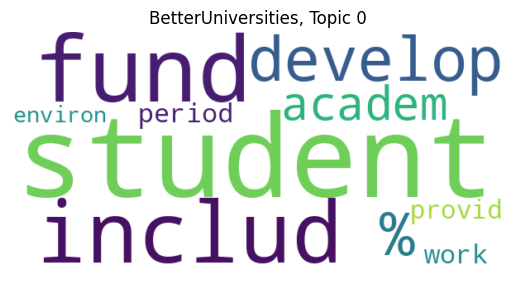

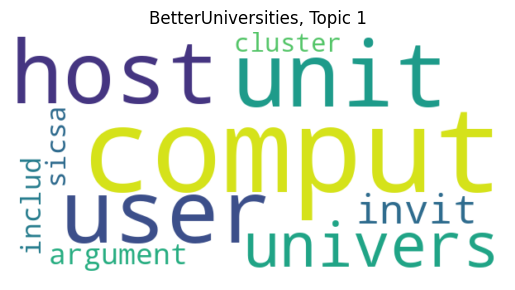

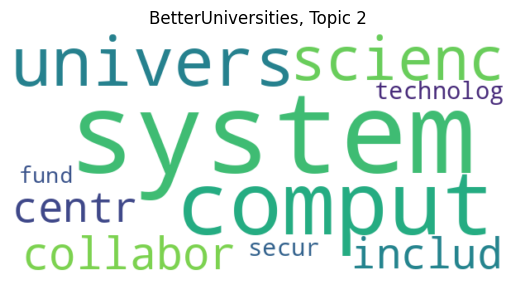

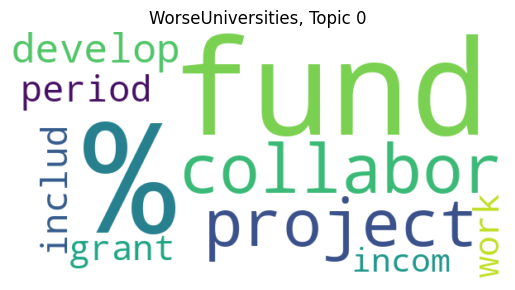

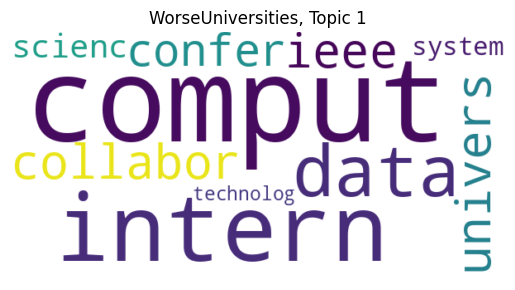

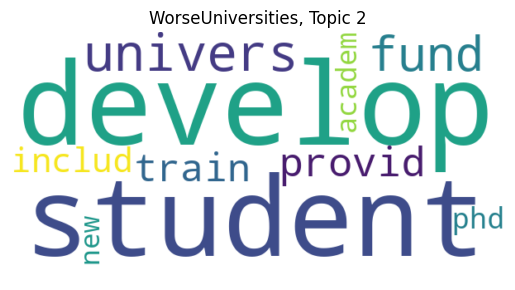

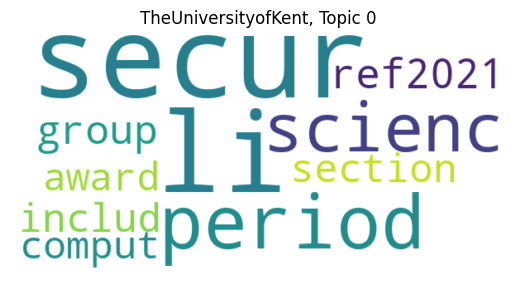

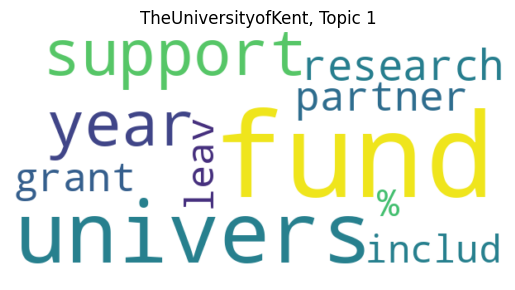

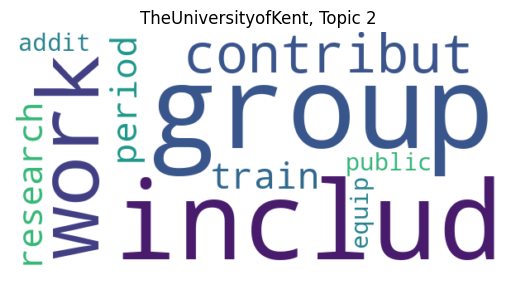

In [7]:
# generate word clouds for the uni's with lda models calculated
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings
# for wordcloud package internal workings errs
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Iterate over each uni / LDA model
for i, uni in enumerate(text_models["lda"].keys()):
    # Iterate over each topic in the model
    for j, topic in enumerate(text_models["lda"][uni].show_topics()):
        # Extract the top 10 words in the topic
        words = dict(text_models["lda"][uni].show_topic(j, topn=10))
        # Create a WordCloud object with the top words
        wordcloud = WordCloud(width=600, height=300, background_color='white').generate_from_frequencies(words)
        # Create a plot with the word cloud image and title
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"{uni}, Topic {j}")
        plt.show()